In [1]:
import pandas as pd
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2 as cv
import tensorflow as tf
import keras
from keras import Model
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Input, Activation, Conv2D, Conv2DTranspose,\
Concatenate, BatchNormalization, MaxPooling2D, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [31]:
print(tf. __version__)
print(keras.__version__)

2.10.0
2.10.0


In [2]:
# Set some parameters
im_height = 128
im_width = 128
im_chan = 1

path_train = '../raw_data/train/'
path_test = '../raw_data/test/'

Prepare train & test images

In [3]:
os.chdir(path_train )
train_img_names = [img_name[0:-4] for img_name in glob.glob('images/*.png')]
train_mask_names = [img_name[0:-4] for img_name in glob.glob('masks/*.png')]
os.chdir('C:/Users/YX/Documents/QX/3rdCap/Salt_Identification_seismic_image/Notebooks')

In [4]:
os.chdir(path_test )
test_img_names = [img_name[0:-4] for img_name in glob.glob('images/*.png')]
test_mask_names = [img_name[0:-4] for img_name in glob.glob('masks/*.png')]
os.chdir('C:/Users/YX/Documents/QX/3rdCap/Salt_Identification_seismic_image/Notebooks')

In [42]:
z_df = pd.read_pickle('../data/depths.pkl')
z_df.head()

,z,qt_cat,trainfile
id,,,
4ac19fb269,306,1,1
1825fadf99,157,0,1
f59821d067,305,1,1
5b435fad9d,503,4,1
e340e7bfca,783,8,1


In [43]:
subset_df = z_df.loc[(z_df['trainfile'] == 1) ] #& (z_df['qt_cat'] == 5)

'8d89d465fc'

In [44]:
# Get and resize train images and masks
X_train = np.zeros((len(subset_df), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(subset_df), im_height, im_width, im_chan), dtype=bool)
# for index, row in subset_df.iterrows():
for i in range(len(subset_df)):
    img = cv.imread(path_train + '/images/' + subset_df.index[i] + '.png',flags = cv.IMREAD_GRAYSCALE )
    mask = cv.imread(path_train + '/masks/' + subset_df.index[i] + '.png',flags = cv.IMREAD_GRAYSCALE )
    X_train[i,...,0] = cv.resize(img, dsize=(128, 128), interpolation=cv.INTER_LINEAR)  # INTER_LINEAR or INTER_CUBIC
    Y_train[i,...,0] = cv.resize(mask, dsize=(128, 128), interpolation=cv.INTER_LINEAR) 


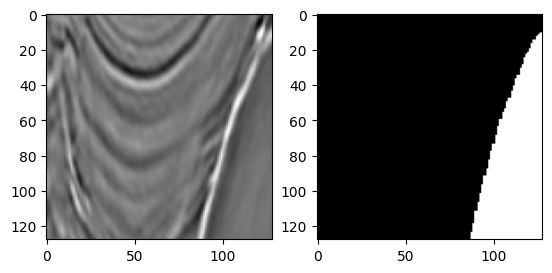

In [9]:
idx = 255
plt.figure()
plt.subplot(1,2,1)
plt.imshow(X_train[idx], cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(Y_train[idx],cmap = 'gray');

In [45]:
X_train.shape, Y_train.shape

((4000, 128, 128, 1), (4000, 128, 128, 1))

## Test a classification problem

In [60]:
bear_salt = np.zeros((len(subset_df),im_chan), dtype=bool)
for i in range(len(subset_df)):
    bear_salt[i,:] = Y_train[i,:,:,0].sum() > 0
bear_salt.sum()

278

In [64]:
bear_salt.shape

(394, 1)

In [72]:
# Initialize the model object
model = Sequential()
# Add a convolutional layer
model.add(Conv2D(10, kernel_size=3, activation='relu', input_shape=(im_height, im_width, 1)))

# Flatten the output of the convolutional layer
model.add(Flatten())
# Add an output layer for the 3 categories
model.add(Dense(1, activation='softmax'))

In [74]:
# Compile the model 
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
print(model.summary())
# Fit the model on a training set
model.fit(X_train, bear_salt, 
          validation_split=0.2, 
          epochs=3, batch_size=10)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 126, 126, 10)      100       
                                                                 
 flatten_1 (Flatten)         (None, 158760)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 158761    
                                                                 
Total params: 158,861
Trainable params: 158,861
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
32/32 [==============================] - 2s 45ms/step - loss: 1144677.1250 - accuracy: 0.7111 - val_loss: 783864.3750 - val_accuracy: 0.6835
Epoch 2/3
32/32 [==============================] - 1s 34ms/step - loss: 588689.7500 - accuracy: 0.7111 - val_loss: 366493.2500 - val_accuracy: 0.6835
Epoch 

## Segmentation

# Define the metric: IoU

In [25]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t, tf.int32)
#         y_pred_ = tf.to_int32(y_pred > t)
        m = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1]) #num_classes=2, 
        m.update_state(y_pred_, y_true)
        score = m.result()
#         K.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#         score = tf.identity(score)
        prec.append(score)
    return tf.math.reduce_mean(prec)

## Unet

Following code of Unet from https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

Q: Why applying two consecutive Convolution Layers?

Q: Why concatenating the transposed conv layers with the feature maps from the encoder at the same level?
To get better precise locations, at every step of the decoder we use skip connections by concatenating the output of the transposed convolution layers with the feature maps from the Encoder at the same level:

u6 = u6 + c4

u7 = u7 + c3

u8 = u8 + c2

u9 = u9 + c1

After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output

In [46]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
#     print(u6.shape, c4.shape)
    u6 = Concatenate()([u6, c4])
#     print(u6.shape)
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = Concatenate()([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = Concatenate()([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = Concatenate()([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [47]:
inputs = Input((im_height, im_width, im_chan))
model = get_unet(inputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # [tf.keras.metrics.MeanIoU(num_classes=2)]
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_115 (Conv2D)            (None, 128, 128, 16  160         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_109 (Batch  (None, 128, 128, 16  64         ['conv2d_115[0][0]']             
 Normalization)                 )                                                           

                                                                                                  
 dropout_53 (Dropout)           (None, 32, 32, 128)  0           ['concatenate_25[0][0]']         
                                                                                                  
 conv2d_127 (Conv2D)            (None, 32, 32, 64)   73792       ['dropout_53[0][0]']             
                                                                                                  
 batch_normalization_121 (Batch  (None, 32, 32, 64)  256         ['conv2d_127[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_121 (Activation)    (None, 32, 32, 64)   0           ['batch_normalization_121[0][0]']
                                                                                                  
 conv2d_tr

Use Keras callbacks to implement:

* Learning rate decay if the validation loss does not improve for 5 continues epochs.
* Early stopping if the validation loss does not improve for 10 continues epochs.
* Save the weights only if there is improvement in validation loss.

In [48]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=8, epochs=3, 
                    callbacks=[earlystopper, checkpointer])

Epoch 1/3
400/400 [==============================] - ETA: 0s - loss: 0.4081 - accuracy: 0.8224
Epoch 1: val_loss improved from inf to 0.54331, saving model to model-tgs-salt-1.h5
400/400 [==============================] - 294s 730ms/step - loss: 0.4081 - accuracy: 0.8224 - val_loss: 0.5433 - val_accuracy: 0.7431
Epoch 2/3
400/400 [==============================] - ETA: 0s - loss: 0.3341 - accuracy: 0.8660
Epoch 2: val_loss improved from 0.54331 to 0.37320, saving model to model-tgs-salt-1.h5
400/400 [==============================] - 289s 722ms/step - loss: 0.3341 - accuracy: 0.8660 - val_loss: 0.3732 - val_accuracy: 0.8170
Epoch 3/3
400/400 [==============================] - ETA: 0s - loss: 0.3127 - accuracy: 0.8759
Epoch 3: val_loss improved from 0.37320 to 0.33916, saving model to model-tgs-salt-1.h5
400/400 [==============================] - 303s 758ms/step - loss: 0.3127 - accuracy: 0.8759 - val_loss: 0.3392 - val_accuracy: 0.8609


## Residual Net